In [ ]:
!pip install networkx

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from google.colab import drive
import os
drive.mount('/content/drive')
wd = '/content/drive/MyDrive/Tesina_Matias/'
os.chdir(wd)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import numpy as np
from matplotlib import pyplot as plt
import os
import networkx as nx
import sys
from scipy import interpolate
from enum import Enum

# Carga de Npy y Filtrado

In [ ]:
# JSD_c = np.load('JSD_Int_c.npy')
JSD_f = np.load('imagenes/JSD/s1a-iw2-slc-hh-20210609INTJSD_f.npy')
JSD_c = np.load('imagenes/JSD/s1a-iw2-slc-hh-20210609INTJSD_c.npy')
JSD_2d = np.load('imagenes/JSD/s1a-iw2-slc-hh-20210609INTJSD_2d.npy')
# JSD_c = np.load('imagenes/DJS/s1a-iw2-slc-hh-20210609INTDJS_f.npy')
# JSD_c = np.load('imagenes/DJS/s1a-iw2-slc-hh-20210609INTDJS_c.npy')
# JSD_c = np.load('imagenes/DJS/s1a-iw2-slc-hh-20210609INTDJS_2d.npy')


# Creacion de la imagen IMPUT correcta

In [ ]:
# La imagen JSD_f esta desplazada por 25 pixeles por un error en la creacion de la imagen, con esto se soluciona, solo la desplazamos 25 px

new_JSD_f = np.zeros((JSD_f.shape[0], JSD_f.shape[1]))

for i in range(0, JSD_f.shape[0]-25):
  for j in range(0, JSD_f.shape[1]):
    new_JSD_f[i,j] = JSD_f[i+25,j]

In [ ]:
def unificate_imgs(img1, img2):
  if(img1.shape != img2.shape):
      print('Las imagenes deben ser igual de tamaño')
      return None

  new_img = np.copy(img1)
  for i in range(0, img1.shape[0]):
    for j in range(0, img1.shape[1]):
      max_elem = max(img1[i,j], img2[i,j])
      new_img[i,j] = max_elem 
      
  return new_img

In [ ]:
JSD = unificate_imgs(JSD_c, new_JSD_f)

### Grafico

Text(0.5, 1.0, 'JSD_2d')

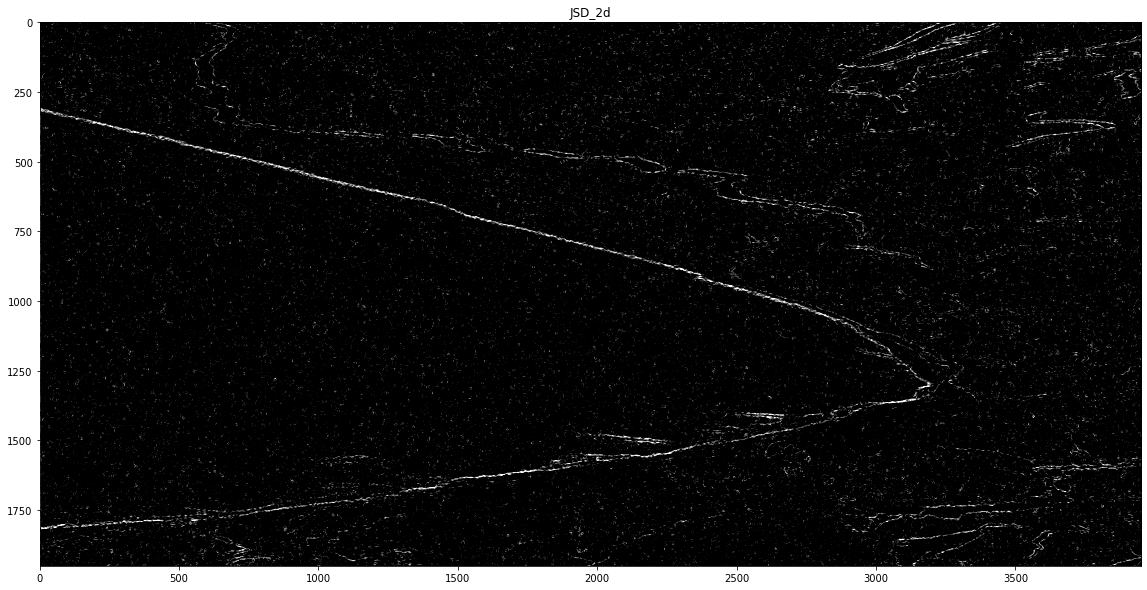

In [ ]:
JSD_max_2d = JSD_2d.max()
JSD_thr_2d = JSD_2d.std() * 2

plt.figure(figsize=(20,10))
plt.imshow(JSD_2d, vmin=JSD_thr_2d, vmax=JSD_max_2d/2, cmap='gray')
plt.title('JSD_2d')

Text(0.5, 1.0, 'JSD')

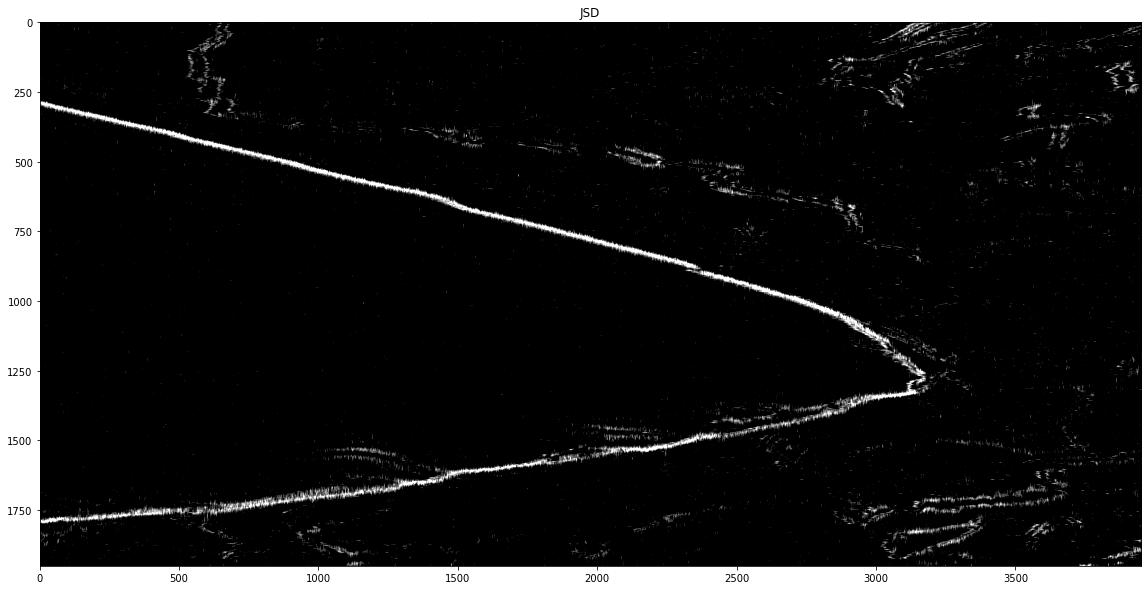

In [ ]:
JSD_max = JSD.max()
JSD_thr = JSD.std() * 2

plt.figure(figsize=(20,10))
plt.imshow(JSD, vmin=JSD_thr, vmax=JSD_max/2, cmap='gray')
plt.title('JSD')

### Filtrado de la imagen imput antes del procesamiento

In [ ]:
#Imagen Filtrada
imgFiltered = np.where((JSD > JSD_thr*2), JSD, 0)

#Imagen Filtrada y binarizada
imgFilteredBin = np.where((JSD > JSD_thr*2), 1, 0)

In [ ]:
#Imagen Filtrada
imgFiltered_2d = np.where((JSD_2d > JSD_thr_2d*2), JSD_2d, 0)

#Imagen Filtrada y binarizada
imgFilteredBin_2d = np.where((JSD_2d > JSD_thr_2d*2), 1, 0)

### Grafico luego del nuevo filtro (opcional)

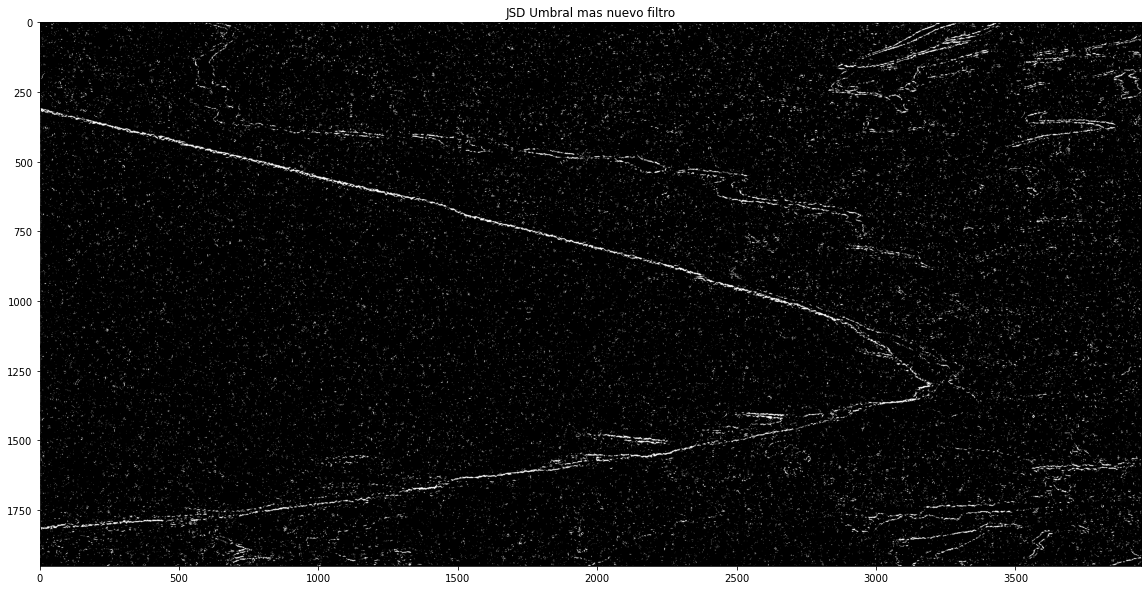

In [ ]:
plt.figure(figsize=(20,10))
plt.title('JSD Umbral mas nuevo filtro')
plt.imshow(imgFilteredBin_2d, cmap='gray')

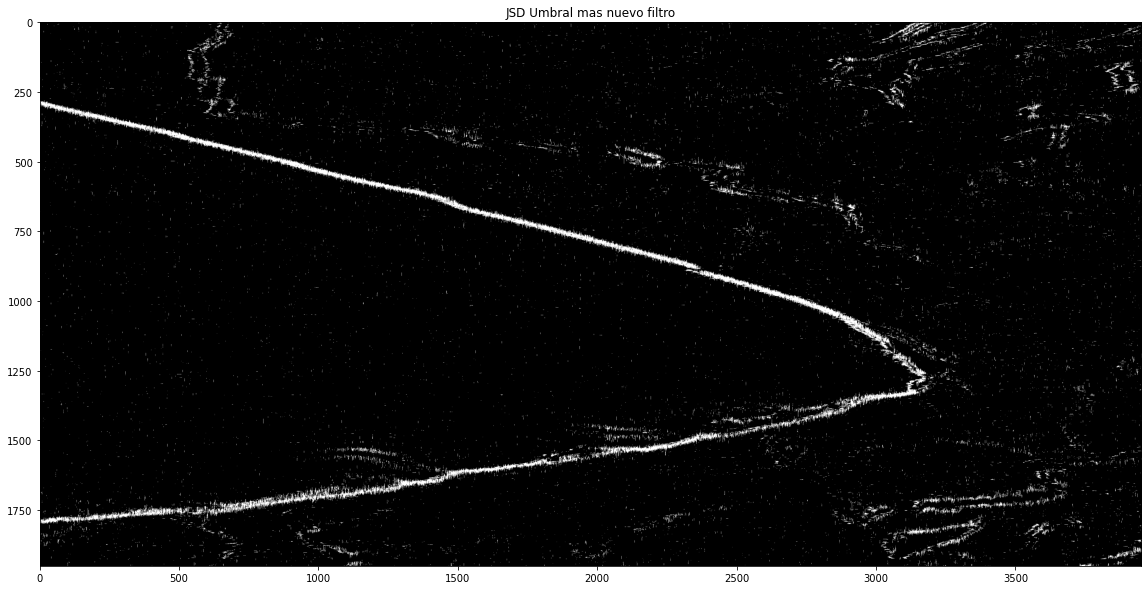

In [ ]:
plt.figure(figsize=(20,10))
plt.title('JSD Umbral mas nuevo filtro')
plt.imshow(imgFilteredBin, cmap='gray')

### Cantidad de puntos y puntos blancos

In [ ]:
print("Cantidad de 1:" , np.sum(imgFilteredBin)) #cuantos 1 tiene la imagen
print("Cantidad de puntos:", imgFilteredBin.shape[0] * imgFilteredBin.shape[1]) #cuantos pixeles tiene la imagen

Cantidad de 1: 192402
Cantidad de puntos: 7702500


# Filtro por bloques N x M

In [ ]:
def get_circle_kernel(radius):
  kernel = np.zeros((2*radius+1, 2*radius+1))
  y, x = np.ogrid[-radius:radius+1, -radius:radius+1]
  mask = x**2 + y**2 <= radius**2
  kernel[mask] = 1
  return kernel

In [ ]:
def filter_circle(imgFiltered, radius, enable_prints=False):
  # luego del filtro anterior procedo a realizar otro filtro por circulo, 
  # divido la imagen original en bloques de n x n y selecciono solo el punto maximo de cada bloque circulo de radio n
  # radius = 3 (recomendado)

  imgBlockBin = np.copy(imgFiltered)
  kernel = get_circle_kernel(radius)

  # El kernel siempre le suma 1 al diametro
  diameter = radius * 2 + 1

  for j in range(0, imgFiltered.shape[1], diameter):
    for i in range(0, imgFiltered.shape[0], diameter):

      aux_array = imgFiltered[i: i + diameter, j : j + diameter]

      if(aux_array.shape == kernel.shape):
        aux_array = aux_array * kernel

      max_elem = np.amax(aux_array)

      if max_elem != 0:
        block_bin = np.where(aux_array == max_elem, 1, 0)
        imgBlockBin[i: i + diameter, j : j + diameter] = block_bin

      else:
        imgBlockBin[i: i + diameter, j : j + diameter] = aux_array

  if enable_prints:
    print("Cantidad de 1 que tenemos ahora:" , np.sum(imgBlockBin))

  return imgBlockBin

In [ ]:
def filter_nxm(imgFiltered, skip_n, skip_m, enable_prints=False):
  # luego del filtro anterior procedo a realizar otro filtro por bloques, 
  # divido la imagen original en bloques de n x m y selecciono solo el punto maximo de cada bloque
  # skip_n = 7 (recomendado)
  # skip_m = 20 (recomendado)

  imgBlockBin = np.copy(imgFiltered)
  imgBlock = np.copy(imgFiltered)

  for j in range(0, imgFiltered.shape[1], skip_n):
    for i in range(0, imgFiltered.shape[0], skip_m):
      max_elem = np.amax(imgFiltered[i: i + skip_m, j : j + skip_n])
      if max_elem != 0:
        block_bin = np.where(imgFiltered[i: i + skip_m, j : j + skip_n] == max_elem, 1, 0)
        # block = np.where(imgFiltered[i: i + skip_m, j : j + skip_n] == max_elem, imgFiltered[i: i + skip_m, j : j + skip_n], 0)
        imgBlockBin[i: i + skip_m, j : j + skip_n] = block_bin
        # imgBlock[i: i + skip_m, j : j + skip_n] = block
  # return imgBlockBin, imgBlock
  if enable_prints:
    print("Cantidad de 1 que tenemos ahora:" , np.sum(imgBlockBin))

  return imgBlockBin

# Creacion de Grafo unico para todo la imagen

In [ ]:
def point_in_range(x_origen, y_origen, x, y, r):
  aux = ((x - x_origen)**2 + (y - y_origen) ** 2 )
  if aux <= (r ** 2) :
      return np.sqrt(aux)
  else: 
    return -1

In [ ]:
def img_to_graph(imgBlockBin, max_range, enable_prints=False):
  # Creacion de un grafo unico uniendo todos los nodos con nodos cercanos en un rango de 20 pixeles de radio
  # max_range = 20 (recomendacion)
  
  G = nx.Graph()
  id = 0
  i_size = imgBlockBin.shape[0]
  j_size = imgBlockBin.shape[1]

  for i in range(0, i_size):
    for j in range(0, j_size):
      if imgBlockBin[i, j] == 1 :
        key = str(i) + '-' + str(j)
        G.add_node(key, coordinates=(i, j), id=id)
        id += 1
        initial_i = max(i - max_range, 0)
        initial_j = max(j - max_range, 0)
        final_i = min(i_size, i + max_range + 1)
        final_j = min(j_size, j + max_range + 1)
        for h in range(initial_i, final_i):
          for k in range(initial_j, final_j):
            if imgBlockBin[h, k] == 1 :
              distance = point_in_range(i, j, h, k, max_range)
              if distance > 0:
                G.add_edge(key, str(h) + '-' + str(k), weight=distance)

  if enable_prints:
    print('Cantidad de nodos del grafo:', len(list(G)))
    print('Cantidad de aristas del grafo', len(G.edges(data=True)))
  return G

# Definicion de algoritmo Kruskal

In [ ]:
def swap(x, y):
  x ^= y; # x := x ^ y
  y ^= x; # y := y ^ (x ^ y) = x
  x ^= y; # x := (x ^ y) ^ x = y
  return x, y

In [ ]:
def uf_find(id, rep, number = 0):
  aux = rep[id]
  if rep[id] < 0 : 
    return id
  rep[id] = uf_find(aux, rep, number + 1)
  return rep[id]

In [ ]:
def uf_join(id1, id2, new_graph, rep, name_list):
  x = uf_find(id1, rep);
  y = uf_find(id2, rep);

  if rep[x] > rep[y]: 
    swap(x, y);

  rep[x] += rep[y];
  rep[y] = x; # positivo

  tuples = (name_list[id1], name_list[id2])
  new_graph.append(tuples)

In [ ]:
def kruskal(grafo):
  distance = sorted(grafo.edges(data=True), key=lambda t: t[2].get('weight', 1))
  nodes = sorted(grafo.nodes(data=True))

  id_list= nx.get_node_attributes(grafo, 'id')

  name_list = [None] * len(nodes)

  for node in nodes:
    name_list[node[1]['id']] = node[0]
  
  rep = np.ones(len(nodes), int) * -1

  new_graph = []
  for elem in distance:
    id1 = id_list[elem[0]]
    id2 = id_list[elem[1]]
    if uf_find(id1, rep) == uf_find(id2, rep):
      pass
    else: 
      uf_join(id1, id2, new_graph, rep, name_list)
  return new_graph, rep

# Creacion del arbol

In [ ]:
def generate_tree(kruskal_list, G, enable_prints=False):
  tree = nx.Graph()
  id_dict = nx.get_node_attributes(G, 'id')
  coordinates_dict = nx.get_node_attributes(G, 'coordinates')
  weight_dict = nx.get_edge_attributes(G, "weight")

  for elem in kruskal_list:
    key1 = elem[0]
    key2 = elem[1]
    tree.add_edge(key1, key2, weight=weight_dict[(key1, key2)])
    tree.add_node(key1, coordinates=coordinates_dict[key1], id=id_dict[key1])
    tree.add_node(key2, coordinates=coordinates_dict[key2], id=id_dict[key2])

  if enable_prints:
    print('Cantidad de nodos del arbol:', len(list(tree)))
    print('Cantidad de aristas del arbol', len(tree.edges(data=True)))

  return tree

In [ ]:
def graph_to_tree(graph):
  # 2s
  kruskal_list, rep = kruskal(graph)
  tree = generate_tree(kruskal_list, graph)
  return tree, rep

#Definicion de finciones para DFS

In [ ]:
def reverse(tuples):
    new_tup = tuples[::-1]
    return new_tup

In [ ]:
def completeList(G):
    aux = list(G.edges)
    list_reversed = aux.copy()
    for i, elem in enumerate(aux):
      list_reversed[i] = reverse(elem)

    return sorted(aux + list_reversed)

In [ ]:
def listToDict(datalist):
  result = {}
  for (key, value) in datalist:
    result.setdefault(key, []).append(value)
  return result

In [ ]:
def dfs_with_end(graph_dic, start, end):
  global visited, road, stack;

  visited = set()
  road = []
  stack = []

  def dfs(x):
    if x in visited: return
    if len(road) != 0: return
    
    visited.add(x)
    stack.append(x)

    if x == end:
      road.extend(np.copy(stack))

    for elem in graph_dic[x]:
      dfs(elem)

    stack.pop()
        
  dfs(start)

  result = np.copy(road)
  
  del visited, stack, road

  return result

## checkeo para saber si el camino entre 2 puntos existe y corrida del DFS

In [ ]:
def is_existing_road(graph, rep, start, end):

  id_dict_tree = nx.get_node_attributes(graph, 'id')

  elem1 = id_dict_tree[start]
  elem2 = id_dict_tree[end]

  if uf_find(elem1, rep) == uf_find(elem2, rep):
    return True
  else:
    return False

In [ ]:
def found_road(graph, rep, start_node, end_node):
  nodes = graph.nodes()

  if not (start_node in nodes):
    print(f'The start_node: ({start_node}) is not a valid node')
    return None

  if not (end_node in nodes):
    print(f'The end_node: ({start_node}) is not a valid node')
    return None

  if is_existing_road(graph, rep, start_node, end_node):
    complete = completeList(graph)
    graphDict = listToDict(complete)

    return dfs_with_end(graphDict, start_node, end_node)

  else:
    print('There is no a road between nodes')
    return None

# Codigo de prueba para encontrar caminos posibles entre la seccion inicial y final, NO ES ALGO NECESARIO

In [ ]:
#Solo para testear
def check_all_roads(graph, rep, initials, endings, enable_prints=False):
  options = []
  id_dict_tree = nx.get_node_attributes(graph, 'id')

  for elem_inicio in initials:
    for elem_final in endings:
      key_1 = str(elem_inicio[0]) + '-' + str(elem_inicio[1])
      key_2 = str(elem_final[0]) + '-' + str(elem_final[1])

      try:
        elem1 = id_dict_tree[key_1]
        elem2 = id_dict_tree[key_2]

        a = uf_find(elem1, rep)
        b = uf_find(elem2, rep)

        if a == b:
          options.append((key_1, key_2))

      except:
        pass

  if enable_prints:
    print('Cantidad de posibles caminos:', len(options))

  return options

Recoracta las cordenadas de todos los puntos en las secciones dadas

In [ ]:
def collect_points(img, x_start, x_end, y_start, y_end):
  aux = np.copy(img[x_start:x_end, y_start:y_end])
  test_list = np.argwhere(aux == 1)
  test_list[:, :1] += x_start
  test_list[:, 1:] += y_start
  return test_list

devuelvo lista de pares (inicio, final)

In [ ]:
def find_valid_extreme_points(imgBlockBin, tree, rep, start_area, end_area):

  #Lista de posibles inicios
  initials = collect_points(imgBlockBin, start_area['y_start'], start_area['y_end'], start_area['x_start'], start_area['x_end'])

  #Lista de posibles finales
  endings = collect_points(imgBlockBin, end_area['y_start'], end_area['y_end'], end_area['x_start'], end_area['x_end'])

  #Prueba todos los posibles inicios con todos los posibles finales para ver cuales de ellos estan conectados
  options = check_all_roads(tree, rep, initials, endings, enable_prints=False)

  return options

# Graficador del resultado con puntos, linea original e interpolacion

In [ ]:
def generate_line(background_img, dotted_road, title='', plot_interpolate_line=True, plot_line=False, plot_dotts=False, k=5, s=10_000):
  x_elems = []
  y_elems = []

  for coordinate in dotted_road:
    aux = coordinate.split('-')
    x_elems.append(int(aux[1]))
    y_elems.append(int(aux[0]))

  tck,u = interpolate.splprep([x_elems,y_elems],k=k,s=s, task=0)

  out = interpolate.splev(u,tck)

  plt.figure(figsize=(20,20))
  plt.imshow(background_img, cmap='gray')
  plt.title(title)

  if plot_dotts:
    plt.plot(x_elems, y_elems, '.', markersize=5, markeredgecolor="red")

  if plot_line:
    plt.plot(x_elems, y_elems, 'g', linewidth='3')

  if plot_interpolate_line:
    plt.plot(out[0], out[1], 'b', linewidth='3')

  plt.show()

# Ejecucion

In [ ]:
class NotBox(Exception):
    pass;

class NotCircle(Exception):
    pass

class NotValidExtremePoints(Exception):
    pass

class NotFilterEnum(Exception):
    pass

class Filter(Enum):
    BOX = 'box'
    CIRCLE = 'circle'

In [ ]:
def run_project(img, range, start_area, end_area, k, s, plot_interpolate_line, plot_line, plot_dotts, background_img, filter_type=Filter.BOX, box=None, circle=None, title=''):
  try:
    sys.setrecursionlimit(10000) # es necesario para que found_road funcione, ya que excede el limite maximo de recursion permitida en Python

    if(not isinstance(filter_type, Filter)):
         raise NotFilterEnum

    # Filtrado de la imagen original por bloques
    if(filter_type.value == 'box'):
      if(box == None):
         raise NotBox
      n = box[0]
      m = box[1]
      imgBlockBin = filter_nxm(img, n, m, enable_prints=False)

    else:
      if(circle == None):
        raise NotCircle
      imgBlockBin = filter_circle(img, circle, enable_prints=False)

    # Creacion del grafo
    G = img_to_graph(imgBlockBin, range, enable_prints=False)

    # Creacion del arbol
    tree, rep = graph_to_tree(G)

    # selecciono los pares de puntos iniciales y finales (esto se puede hacer manualmente)
    extreme_points = find_valid_extreme_points(imgBlockBin, tree, rep, start_area, end_area)

    #Si hay caminos posibles elegimos uno y generamos la linea
    if extreme_points:
      #elegimos el punto inicial y final
      start_node = extreme_points[0][0]
      end_node = extreme_points[0][1]
      print('Start:', start_node, 'End:', end_node)

      # Corremos DFS en el arbol para encontrar el camino
      dotted_road = found_road(tree, rep, start_node, end_node)

      print("cantidad de nodos del camino:", len(dotted_road))

      generate_line(background_img, dotted_road, title, plot_interpolate_line=plot_interpolate_line, plot_line=plot_line, plot_dotts=plot_dotts, k=k, s=s)

    else:
     raise NotValidExtremePoints

  except NotFilterEnum: 
      print('filter_type no es de tipo Filter')

  except NotBox: 
      print('Es necesario un box = (n, m)')

  except NotCircle: 
      print('Es necesario un Circle = radium')

  except NotValidExtremePoints: 
     print('No existen caminos posibles entre los puntos iniciale y finales')

#JSD_2d

Start: 310-1 End: 1810-1
cantidad de nodos del camino: 5383


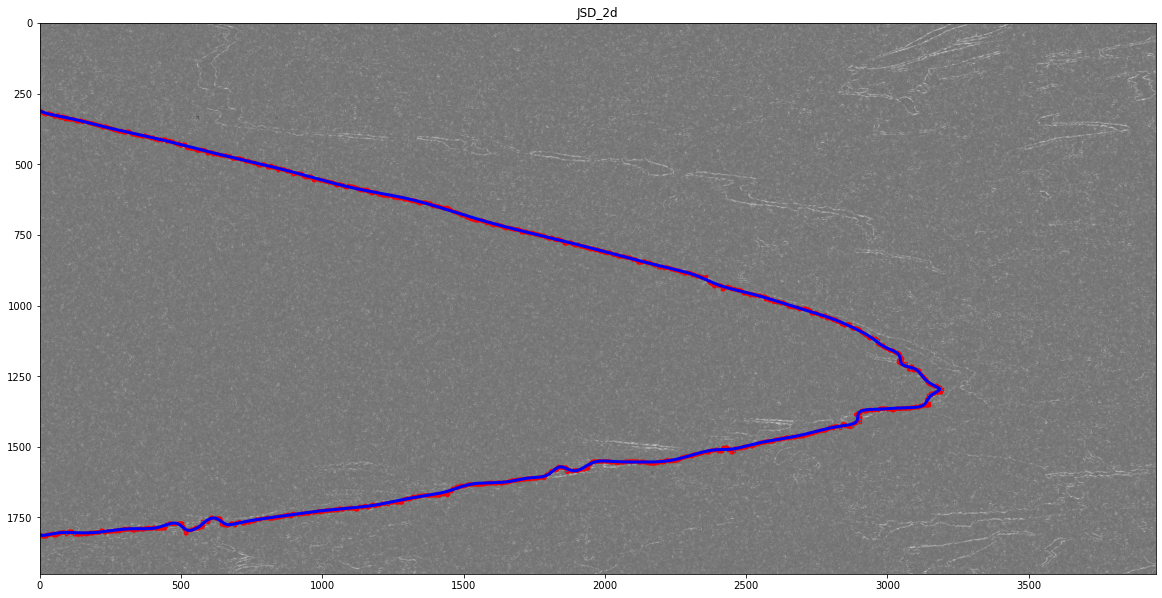

In [ ]:
### JSD_2d ###
###### area inicial ######
start_area = { 
'x_start': 0, 
'x_end': 20,
'y_start': 310,
'y_end': 320
}
##########################

### JSD_2d ###
###### area final #########

end_area = { 
'x_start': 0, 
'x_end': 20,
'y_start': 1810,
'y_end': 1820
}
###########################

# run_project(img=imgFiltered_2d, box=(5,20), circle=None, range=20, filter_type="Box", 
            # start_area=start_area, end_area=end_area, background_img=JSD_2d,
            # k=5, s=50_000, plot_interpolate_line=True, plot_line=False, plot_dotts=True, title='JSD_2d)

run_project(img=imgFiltered_2d, box=(1,30), circle=None, range=20, filter_type=Filter.BOX, 
            start_area=start_area, end_area=end_area, background_img=JSD_2d,
            k=5, s=50_000, plot_interpolate_line=True, plot_line=False, plot_dotts=True, title='JSD_2d')

#JSD FIL+COL

In [ ]:
# FIL+COL
####### area inicial ######
start_area = { 
'x_start': 0, 
'x_end': 10,
'y_start': 285,
'y_end': 300
}
###########################

# FIL+COL
###### area final #########
end_area = { 
'x_start': 0, 
'x_end': 10,
'y_start': 1785,
'y_end': 1795
}
###########################

# run_project(img=imgFiltered, title='JSD_FIL+COL', box=(7,20), range=23, filter_type=Filter.BOX,
#             start_area=start_area, end_area=end_area, background_img=JSD,
#             k=5, s=50_000, plot_interpolate_line=True, plot_line=False, plot_dotts=True)

run_project(img=imgFiltered, title='JSD_FIL+COL', box=(1,1), range=5, filter_type=Filter.BOX,
            start_area=start_area, end_area=end_area, background_img=JSD,
            k=5, s=50_000, plot_interpolate_line=False, plot_line=False, plot_dotts=True)

KeyboardInterrupt: ignored

# EXTRA

In [ ]:
def show_area(img, x_start, x_end, y_start, y_end):
  plt.figure(figsize=(10,10))
  plt.title('JSD Umbral mas nuevo filtro')
  plt.imshow(img[x_start:x_end,y_start:y_end], cmap='gray')

In [ ]:
####### area inicial ######
x_start = 0
x_end = 10
y_start = 285
y_end = 300
###########################

###### area final #########
x_start_2 = 0
x_end_2 = 10
y_start_2 = 178
y_end_2 = 1800
###########################

# show_area(imgFilteredBin, y_start,  y_end, x_start, x_end)
# show_area(imgFilteredBin, y_start_2,  y_end_2, x_start_2, x_end_2)